---
title: Detectors
authors: [gvarnavides]
date: 2025-02-01
---

In [2]:
# %matplotlib widget

import abtem
import ase
import numpy as np
import matplotlib.pyplot as plt

# import py4DSTEM
from scipy.ndimage import rotate

abtem.config.set({"dask.lazy":False});

## Atoms and Potential

In [3]:
srtio3_unit_cell = ase.io.read("data/SrTiO3.cif")
srtio3 = srtio3_unit_cell*(6,6,2)
gpts = (192,192)
scan_gpts = (32,32) # Double Nyquist later
energy = 200e3
semiangle_cutoff = 20

In [4]:
potential = abtem.Potential(
    srtio3,
    gpts=gpts,
    slice_thickness=srtio3.cell[2,2]/8,
    projection='finite'
).build(
)

In [5]:
probe_in_focus = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
).match_grid(
    potential
)

## Scans

In [6]:
custom_positions = srtio3_unit_cell.positions[:4,:2]
custom_scan = abtem.CustomScan(
    positions=custom_positions
)

In [7]:
line_scan = abtem.LineScan(
    start=(0,0),
    end=np.array(potential.extent)/6,
    gpts=scan_gpts[0]*4
)

In [8]:
grid_scan = abtem.GridScan(
    start=(0,0),
    end=np.array(potential.extent)/6,
    gpts=scan_gpts,
)

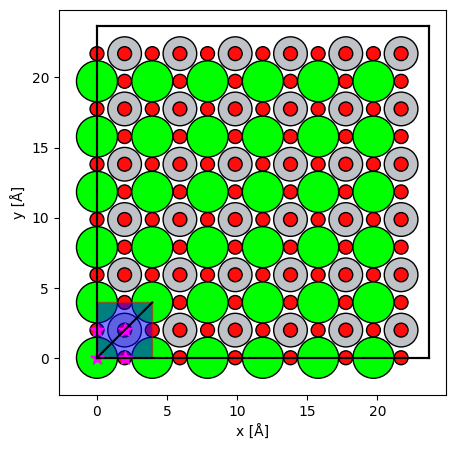

In [9]:
#| label: app:detectors_scans
fig,ax = plt.subplots(figsize=(5,5))
abtem.show_atoms(
    srtio3,
    ax=ax
)
grid_scan.add_to_plot(ax,alpha=0.5,facecolor='b')
line_scan.add_to_axes(ax,color='k')
ax.scatter(custom_positions[:,1],custom_positions[:,0],c='magenta',marker='*',s=100);

In [10]:
# exit_waves_custom = probe_in_focus.multislice(potential,scan=custom_scan)
exit_waves_line = probe_in_focus.multislice(potential,scan=line_scan)
exit_waves_grid = probe_in_focus.multislice(potential,scan=grid_scan)

## Monolithic Detectors

In [11]:
bright = abtem.AnnularDetector(inner=0, outer=25)
maadf = abtem.AnnularDetector(inner=25, outer=65)
haadf = abtem.AnnularDetector(inner=65, outer=100)

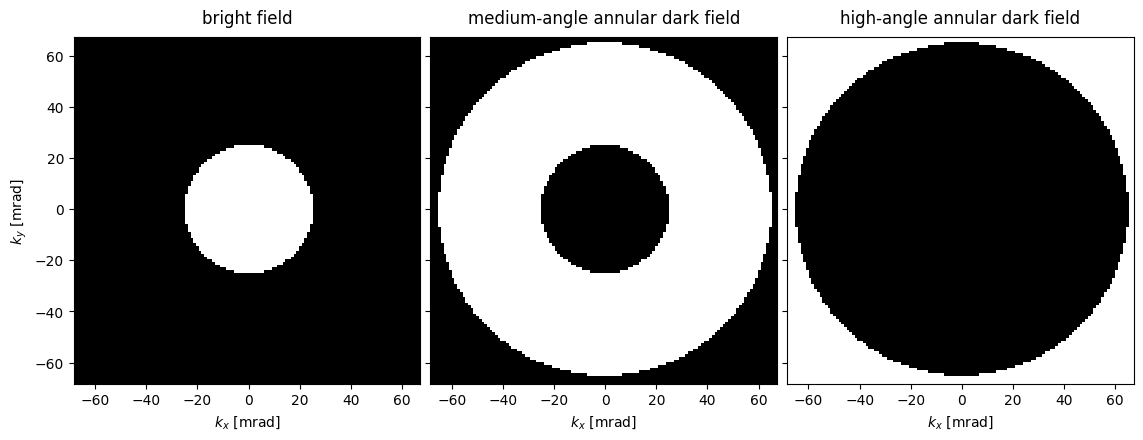

In [12]:
#| label: app:detectors_monolithic
bright_region = bright.get_detector_region(probe_in_focus)
maadf_region = maadf.get_detector_region(probe_in_focus)
haadf_region = haadf.get_detector_region(probe_in_focus)

labels = ("bright field", "medium-angle annular dark field", "high-angle annular dark field")
stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), labels
)

visualization = stacked_regions.show(
    explode=True,units="mrad", figsize=(12,4.5),
    cmap='gray'
)

## Measurements

In [13]:
line_measurement_bright = bright.detect(exit_waves_line)
line_measurement_maadf = maadf.detect(exit_waves_line)
line_measurement_haadf = haadf.detect(exit_waves_line)

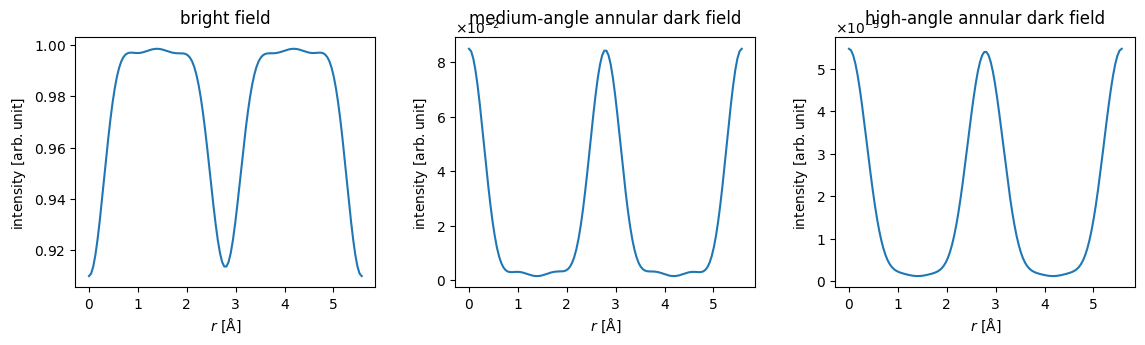

In [14]:
#| label: app:detectors_monolithic_line
line_measurements = abtem.stack(
    [
        line_measurement_bright,
        line_measurement_maadf,
        line_measurement_haadf
    ],
    labels
)

visualization = line_measurements.show(explode=True,common_scale=False, figsize=(12, 3))

In [15]:
grid_measurement_bright = bright.detect(exit_waves_grid)
grid_measurement_maadf = maadf.detect(exit_waves_grid)
grid_measurement_haadf = haadf.detect(exit_waves_grid)

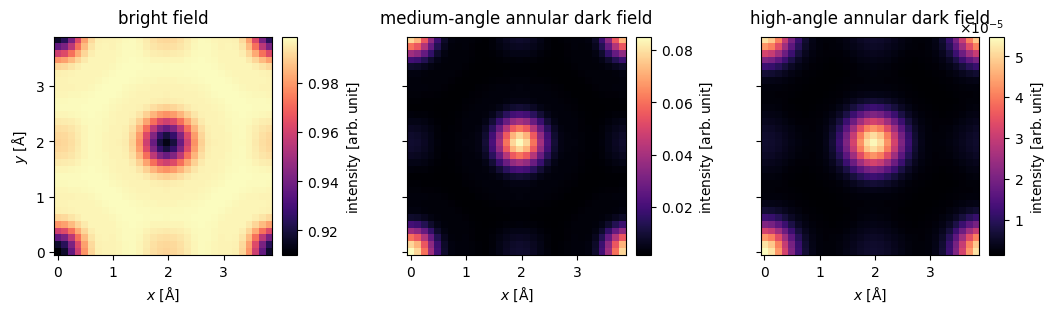

In [16]:
#| label: app:detectors_monolithic_grid
grid_measurements = abtem.stack(
    [
        grid_measurement_bright,
        grid_measurement_maadf,
        grid_measurement_haadf
    ],
    labels
)

visualization = grid_measurements.show(explode=True, cbar=True, figsize=(12, 3),cmap='magma')

## Pixelated Detectors

In [17]:
cropped_gpts = (gpts[0]//2,gpts[1]//2)

pixelated_detector = abtem.PixelatedDetector(max_angle=None)
grid_measurement_pixelated = pixelated_detector.detect(
    exit_waves_grid
).crop(
    gpts=(gpts[0]//2,gpts[1]//2)
)

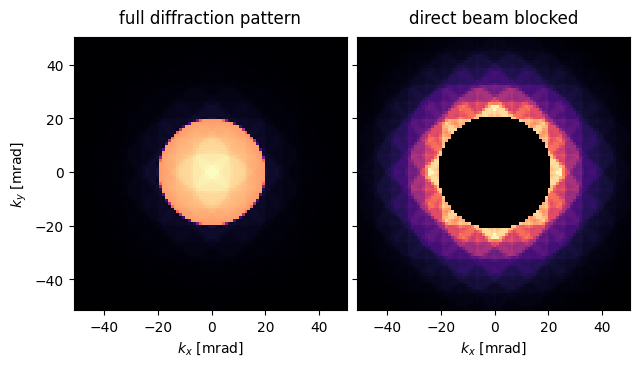

In [18]:
#| label: app:detectors_pixelated
abtem.stack(
    [
        grid_measurement_pixelated[0,0],
        grid_measurement_pixelated[0,0].block_direct()
    ],
    ("full diffraction pattern","direct beam blocked")
).show(
    explode=True,
    units="mrad",
    cmap='magma'
);

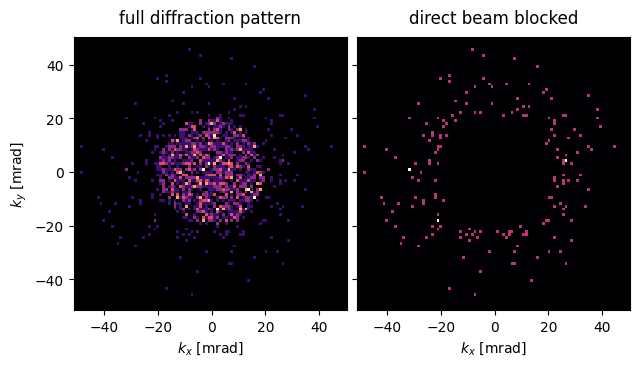

In [19]:
#| label: app:detectors_pixelated_postprocessed
grid_measurement_pixelated_postprocessed = grid_measurement_pixelated.copy()
grid_measurement_pixelated_postprocessed._array = rotate(
    grid_measurement_pixelated_postprocessed.array,
    angle = 15, #deg
    order=1,
    reshape=False,
    axes=(-1,-2)
).clip(0)

grid_measurement_pixelated_postprocessed = grid_measurement_pixelated_postprocessed.poisson_noise(
    dose_per_area=1e5
)

abtem.stack(
    [
        grid_measurement_pixelated_postprocessed[0,0],
        grid_measurement_pixelated_postprocessed[0,0].block_direct(radius=semiangle_cutoff+0.25)
    ],
    ("full diffraction pattern","direct beam blocked")
).show(
    explode=True,
    units="mrad",
    cmap='magma'
);

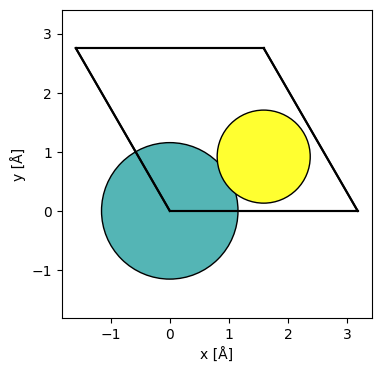

In [20]:
atoms = ase.build.mx2(vacuum=2)

abtem.show_atoms(atoms,figsize=(4,4))

plane_wave = abtem.PlaneWave(energy=80e3, sampling=0.05)

exit_wave = plane_wave.multislice(atoms)

In [21]:
energy = 80e3
Cs = -20e-6 * 1e10
focal_spread = 52.50

# Simulate coherent image
ctf_coherent = abtem.CTF(Cs=Cs, energy=energy)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity().compute()

# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity
image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity().compute()

In [22]:
defocus_distribution = abtem.distributions.gaussian(
    center=ctf_coherent.defocus,
    standard_deviation=focal_spread,
    num_samples=7,
    sampling_limit=1.5,
)

ctf_incoherent = ctf_coherent.copy()
ctf_incoherent.defocus = defocus_distribution

In [23]:
images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()

images_incoherent.compute()

images_incoherent.axes_metadata

type           label    coordinates
-------------  -------  -----------------------
ParameterAxis  C10 [Å]  190.67 164.42 ... 33.17
RealSpaceAxis  x [Å]    0.00 0.05 ... 3.13
RealSpaceAxis  y [Å]    0.00 0.05 ... 5.46

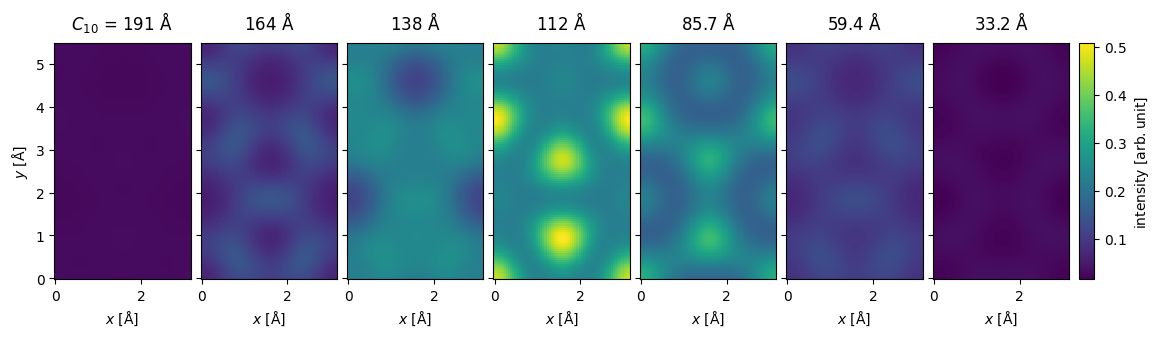

In [24]:
images_incoherent.show(
    explode=True,
    figsize=(13, 5),
    common_color_scale=True,
    cbar=True,
);

In [25]:
image_incoherent = images_incoherent.sum(0)

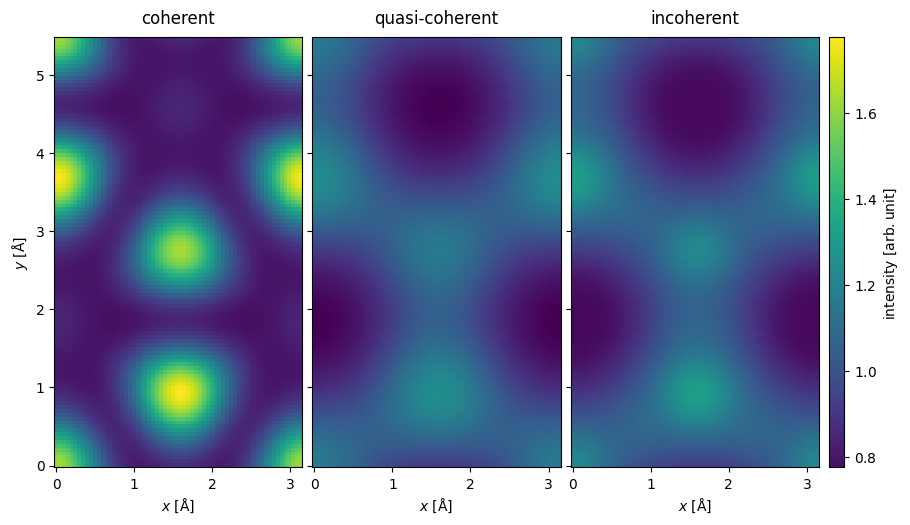

In [26]:
stack = abtem.stack(
    [image_coherent, image_quasi_coherent, image_incoherent],
    ("coherent", "quasi-coherent", "incoherent"),
)

stack.show(
    common_color_scale=True,
    explode=True,
    cbar=True,
    figsize=(18, 5),
);

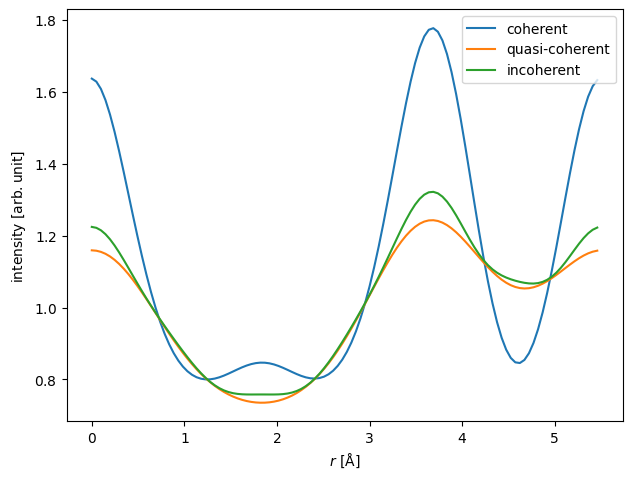

In [27]:
stack.interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show(legend=True);

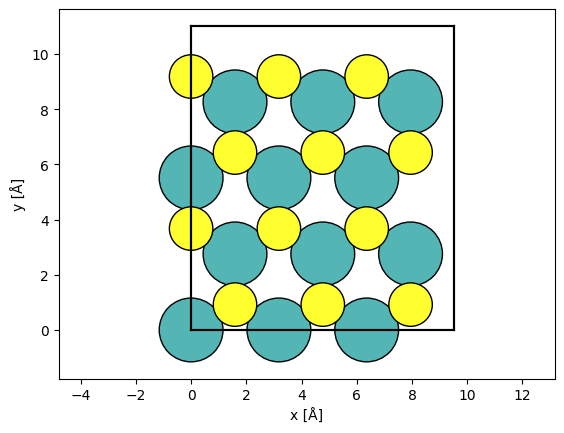

In [28]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (3, 2, 1)

abtem.show_atoms(atoms);

In [29]:
energy = 80e3
probe_coherent = abtem.Probe(energy=energy, semiangle_cutoff=30, sampling=0.05)

In [30]:
chromatic_aberration = 1.0 * 1e-3 * 1e10
energy_spread = 0.15
focal_spread = chromatic_aberration * energy_spread / energy

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

print("Focal spread =", focal_spread, "Å")

Focal spread = 18.75 Å


In [31]:
probe_temporal = abtem.Probe(
    energy=energy, semiangle_cutoff=30, sampling=0.05, defocus=defocus_distribution
)

detector = abtem.PixelatedDetector()

scan = abtem.GridScan((0, 0), (1 / 3, 1 / 2), fractional=True, potential=atoms)

In [32]:
measurement_coherent = probe_coherent.scan(
    atoms, detectors=detector, scan=scan
).compute()

measurement_temporal = probe_temporal.scan(
    atoms, detectors=detector, scan=scan
).compute()

In [33]:
source_size = 0.3

measurement_spatial = measurement_coherent.gaussian_source_size(source_size)
measurement_temporal_spatial = measurement_temporal.gaussian_source_size(source_size)

In [34]:
stacked = abtem.stack(
    (
        measurement_coherent,
        measurement_temporal,
        measurement_spatial,
        measurement_temporal_spatial,
    ),
    ("coherent", "temporal", "spatial", "temporal + spatial"),
)

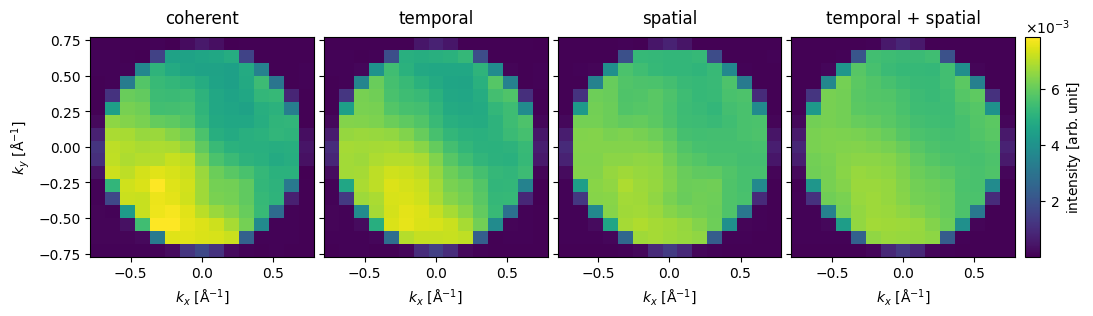

In [35]:
stacked[:, 1, 1].crop(30).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
);

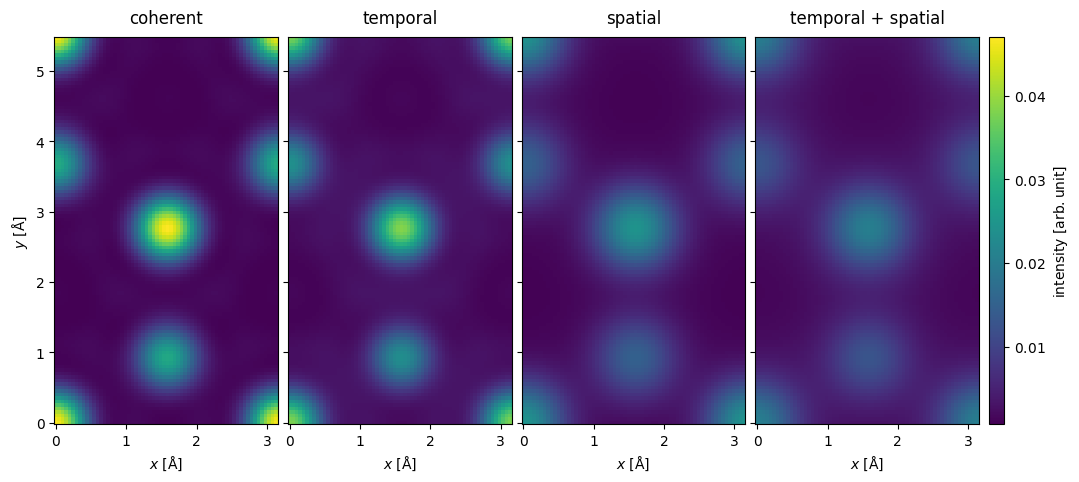

In [36]:
stacked.integrate_radial(50, 150).interpolate(0.05).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
);

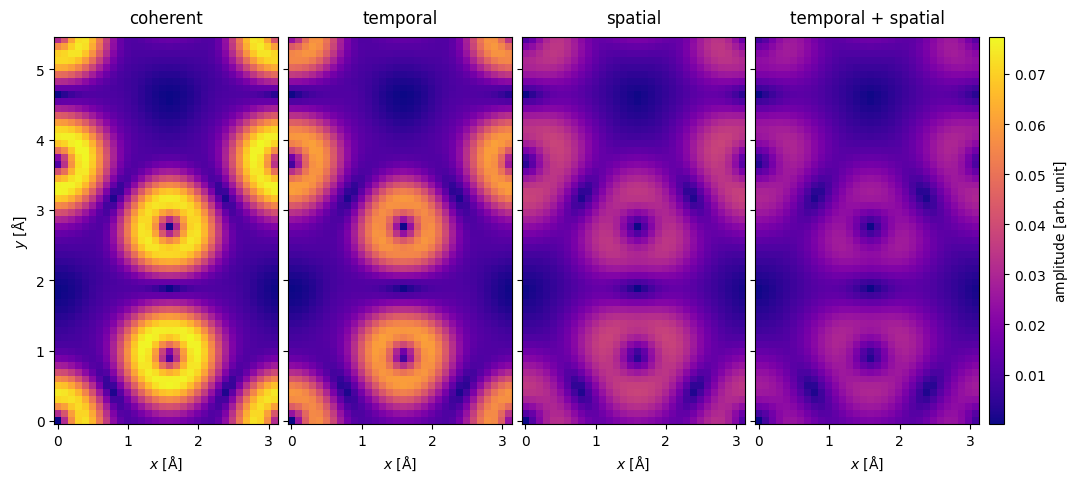

In [37]:
stacked.center_of_mass().interpolate(0.1).abs().show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
    cmap="plasma",
);

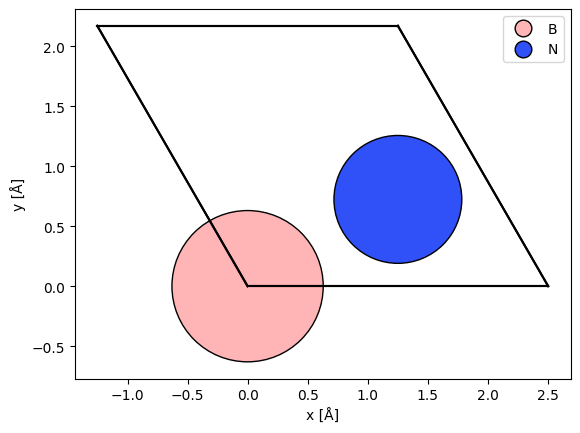

In [47]:


atoms = ase.build.graphene(vacuum=3, a=2.504)

atoms[0].number = 5
atoms[1].number = 7

abtem.show_atoms(atoms, legend=True);

In [48]:
from gpaw import GPAW

gpaw = GPAW(txt=None, kpts=(5, 5, 1))
atoms.calc = gpaw

In [49]:
atoms.get_potential_energy()

-19.369576502082364

In [53]:
from gpaw import GPAW, PW
potential_dft = abtem.GPAWPotential(gpaw, sampling=0.04).build().compute()

RuntimeError: This functionality of abTEM requires GPAW, see https://wiki.fysik.dtu.dk/gpaw/.

In [2]:
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.bloch import BlochWaves, StructureFactor

import abtem

abtem.config.set(
    {
        "precision": "float64",
        "device": "cpu",
    }
)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

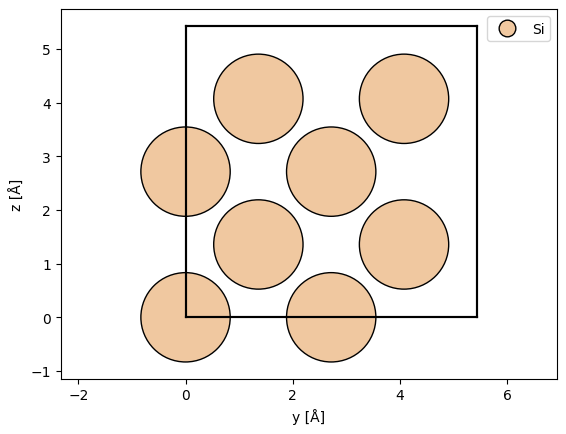

In [3]:
atoms = ase.build.bulk("Si", cubic=True)

abtem.show_atoms(atoms, legend=True, plane="yz")

In [4]:
k_max = 12

structure_factor = StructureFactor(
    atoms,
    g_max=k_max,
    parametrization="lobato",
    thermal_sigma=0.078
)

In [5]:
sg_max = 0.1

bloch_waves = BlochWaves(
    structure_factor=structure_factor,
    energy=200e3,
    sg_max=sg_max,
)

In [6]:
len(bloch_waves)

3573

In [7]:
bloch_waves.hkl

array([[ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  2,  0],
       ...,
       [-1, -3,  0],
       [-1, -2,  0],
       [-1, -1,  0]])

In [8]:
thicknesses = np.arange(0, 1086 + 0.1, 5.43)

diffraction_thickness_series = bloch_waves.calculate_diffraction_patterns(thicknesses)

diffraction_thickness_series

[########################################] | 100% Completed | 144.81 s


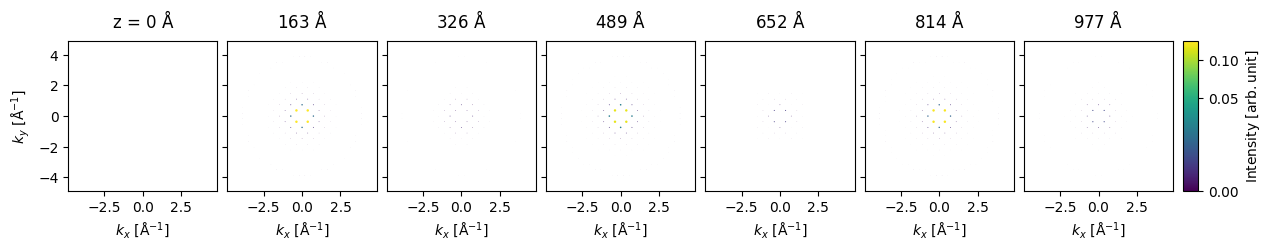

In [9]:
diffraction_thickness_series[::30].crop(k_max=4.5).block_direct().show(
    explode=True,
    scale=0.08,
    power=0.5,
    annotations=False,
    figsize=(14, 5),
    common_color_scale=True,
    cbar=True,
)

In [10]:
data_array = diffraction_thickness_series.to_data_array()

KeyboardInterrupt: 

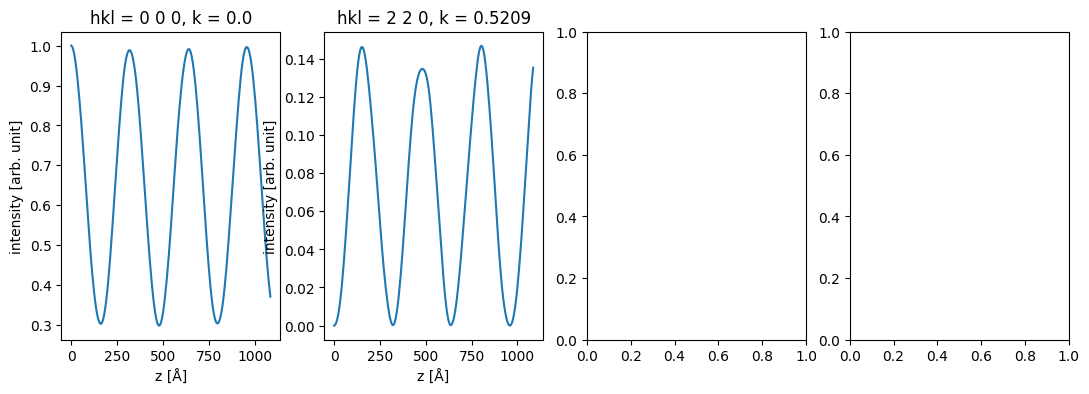

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="hkl", ax=ax)

plt.tight_layout()

In [11]:
x = np.linspace(0, np.pi / 4, 4)
z = np.linspace(0, np.pi / 4, 4)

ensemble = bloch_waves.rotate("z", z, "x", x)

ensemble

In [23]:
diffraction_patterns = ensemble.calculate_diffraction_patterns(thicknesses=100)

diffraction_patterns.array

dask.array<getitem, shape=(4, 4, 32283), dtype=float64, chunksize=(1, 1, 32283), chunktype=numpy.ndarray>

In [ ]:
print('he')

hello world


In [22]:

diffraction_patterns[0].compute()

[                                        ] | 0% Completed | 8.96 ms

[############                            ] | 30% Completed | 8.73 s ms


KeyboardInterrupt: 

In [ ]:
diffraction_patterns.shape

In [ ]:
diffraction_patterns = diffraction_patterns.remove_low_intensity(1e-6)

In [ ]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.03,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
)

In [ ]:
z = np.tile([np.pi / 4], (4,))
x = np.linspace(0, np.pi / 2, 4)

rotations = np.array([z, x, -z]).T

In [ ]:
ensemble = bloch_waves.rotate("zxz", rotations)

diffraction_patterns = ensemble.calculate_diffraction_patterns(1000).compute()

In [ ]:
diffraction_patterns.crop(k_max=4).block_direct().show(
    explode=True,
    scale=0.03,
    power=0.5,
    annotation_kwargs={"threshold": 1},
    figsize=(14, 14),
)

In [ ]:
k_max = 12

structure_factor = StructureFactor(
    atoms, k_max=k_max, parametrization="lobato", centering="F", thermal_sigma=0.078
)

In [ ]:
potential_sf = structure_factor.get_projected_potential(slice_thickness=0.5)

potential_sf.sampling

In [ ]:
parametrization = abtem.parametrizations.LobatoParametrization(
    sigmas={"Si": 0.078 * np.sqrt(3)}
)

potential = (
    abtem.Potential(
        atoms,
        sampling=potential_sf.sampling,
        slice_thickness=0.1,
        projection="finite",
        parametrization=parametrization,
    )
    .build()
    .compute(progress_bar=False)
)

In [ ]:
stack = abtem.stack(
    (potential.project(), potential_sf.project()), ("Direct", "From structure factor")
).compute()

stack.show(explode=True, common_color_scale=True, cbar=True);

In [ ]:
pw = abtem.PlaneWave(energy=200e3)

nz = int(1086 / potential.thickness)

repeated_potential = abtem.CrystalPotential(
    potential, repetitions=[1, 1, nz], exit_planes=potential.num_slices
)

exit_waves_ms = pw.multislice(potential=repeated_potential).compute()

In [ ]:
bloch_waves = BlochWaves(
    structure_factor=structure_factor, energy=200e3, sg_max=sg_max, paraxial=True
)

len(bloch_waves)

In [ ]:
exit_waves_bw = bloch_waves.calculate_exit_wave(
    repeated_potential.exit_thicknesses, gpts=exit_waves_ms.gpts
)

In [ ]:
exit_waves_bw.shape

In [ ]:
exit_waves_ms.shape

In [ ]:
stack.shape

In [ ]:
stack[1::30].show(explode=True, figsize=(12, 4))

In [ ]:
stacked_diffraction = (
    stack.to_cpu().diffraction_patterns().index_diffraction_spots(cell=atoms)
)

In [ ]:
data_array = stacked_diffraction.to_data_array()

fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, hkl in zip(axes, ["0 0 0", "2 2 0", "4 0 0", "-21 1 -1"]):
    data_array.sel(hkl=hkl).plot(hue="algorithm", ax=ax)

plt.tight_layout()